# Final Project
## outline:
    - Investigate the given data:
        - Investigate train data set and distribution of variables
        - Look into the Test data set and compare to the train data set
        - summarize data from the train labels
    - Data pre-proccessing plan:
        - Walk through the steps with a single installation ID
        - pre-process a large portion of the data
        - investigate the the features in relation to accuracy group
    - Machine learning model:
        - fit KNN model to the processed data
        - fit SGD model for comparison
        - evalute model and get cohen kappa score and accuracy on train data
    - Submission:
        - preproccess test data to fit model correctly
        - make predictions using the best model weve created

## Explore the Data

The first step we want to do is read in all of our data and preprare our packages

In [163]:
import pandas as pd
import numpy as np
%matplotlib inline
train = pd.read_csv('train.csv')
train_labels = pd.read_csv('train_labels.csv')
test = pd.read_csv('test.csv')

In [137]:
train.head()

,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world
0,27253bdc,45bb1e1b6b50c07b,2019-09-06T17:53:46.937Z,"{""event_code"": 2000, ""event_count"": 1}",0001e90f,1,2000,0,Welcome to Lost Lagoon!,Clip,NONE
1,27253bdc,17eeb7f223665f53,2019-09-06T17:54:17.519Z,"{""event_code"": 2000, ""event_count"": 1}",0001e90f,1,2000,0,Magma Peak - Level 1,Clip,MAGMAPEAK
2,77261ab5,0848ef14a8dc6892,2019-09-06T17:54:56.302Z,"{""version"":""1.0"",""event_count"":1,""game_time"":0...",0001e90f,1,2000,0,Sandcastle Builder (Activity),Activity,MAGMAPEAK
3,b2dba42b,0848ef14a8dc6892,2019-09-06T17:54:56.387Z,"{""description"":""Let's build a sandcastle! Firs...",0001e90f,2,3010,53,Sandcastle Builder (Activity),Activity,MAGMAPEAK
4,1bb5fbdb,0848ef14a8dc6892,2019-09-06T17:55:03.253Z,"{""description"":""Let's build a sandcastle! Firs...",0001e90f,3,3110,6972,Sandcastle Builder (Activity),Activity,MAGMAPEAK


Were first going to do some very basic feature engineering on our train data set. Since I haven't previously dealt with time stamps I've decided to reformat that data into something I'm more familiar with.

In [143]:
train['timestamp'] = pd.to_datetime(train['timestamp'])
train['date'] = train['timestamp'].dt.date
train['hour'] = train['timestamp'].dt.hour
train['weekday_name'] = train['timestamp'].dt.weekday_name

### investigate train data

The first data set we want to take a look at is the train data set. However, because creating visualizations with such a large amount of data would take a lot of computing time, we will be using a sample of 10000 rows.

In [53]:
train_sample = train.sample(10000)

In [50]:
train_sample.head()

,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world,date,hour,weekday_name
1438910,ab3136ba,5bd4b6981fb96f1f,2019-08-22 00:13:14.003,"{""description"":""The warm-up is over, folks. Le...",206e5f51,18,3110,31930,Dino Dive,Game,MAGMAPEAK,2019-08-22,0,Thursday
5053935,1325467d,3371edd2fadc9d35,2019-08-25 19:20:59.361,"{""coordinates"":{""x"":884,""y"":181,""stage_width"":...",717f1d3a,3,4070,1514,Sandcastle Builder (Activity),Activity,MAGMAPEAK,2019-08-25,19,Sunday
5727156,51102b85,cec10265833e5d0c,2019-08-09 16:06:50.884,"{""hat"":5,""caterpillar"":"""",""coordinates"":{""x"":2...",7f012464,39,4030,31543,Bird Measurer (Assessment),Assessment,TREETOPCITY,2019-08-09,16,Friday
7494410,2230fab4,e17e15aa1f0751df,2019-08-18 14:58:51.154,"{""description"":""That's not enough food. Try pu...",a6ea082f,72,3120,85022,Chow Time,Game,CRYSTALCAVES,2019-08-18,14,Sunday
3640238,cf82af56,ae5f0da93abd1a96,2019-09-14 09:23:58.650,"{""coordinates"":{""x"":816,""y"":375,""stage_width"":...",505c0a39,17,4070,12159,Scrub-A-Dub,Game,MAGMAPEAK,2019-09-14,9,Saturday


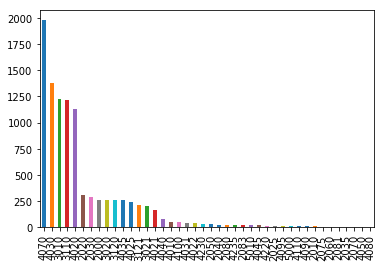

In [10]:
train_sample.event_code.value_counts().plot.bar()

We note that the most popular event codes are 4070, 4030, and 3010

Since our goal is to predict assessment scores for installation ids, we should look at what percentage of installs, actually go on to even attempt an assessment

In [11]:
print('num of installation IDS: ', (len(train_sample.installation_id.unique())))
print('num of installs that attempted assessment ', train_sample.groupby('installation_id').type.value_counts().unstack().Assessment.count())
percent = train_sample.groupby('installation_id').type.value_counts().unstack().Assessment.count() / len(train_sample.installation_id.unique())
print('percentage ', percent )

num of installation IDS:  4378
num of installs that attempted assessment  671
percentage  0.15326633165829145


Just 15% of our sample of installation ID's ever attempt an assessment.

One feature we created earlier was days of the week. Lets see if children are more likely to play on different days.

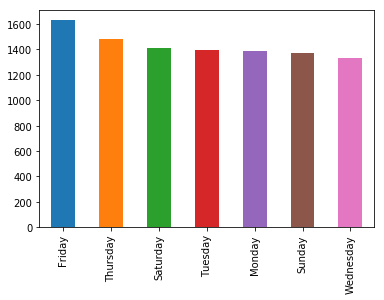

In [54]:
train_sample.weekday_name.value_counts().plot.bar()

It appears Friday and Thursday are the most popular days for the app. However, all days are relatively similiar.

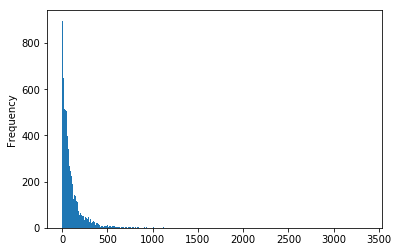

In [55]:
train_sample.event_count.plot.hist(bins=500)

Looking at the distribution of event count, we can see that its strongly skewed right with the vase majority close to 0.
Interestingly, we see several values over 500. Its fair to wonder is this an error, or are there really children playing this much of the measure up app.

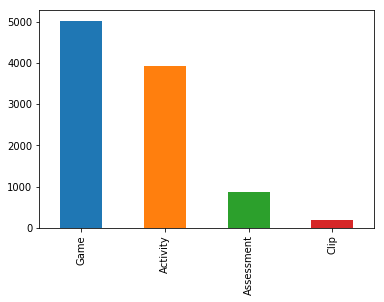

In [56]:
train_sample.type.value_counts().plot.bar()

Among the sample, games are the most popular event type. there could be several reasons for this. Its possible that users do play more games then they participate with activitys or assesments, but its also possible that interacting with a game simply creates more events.

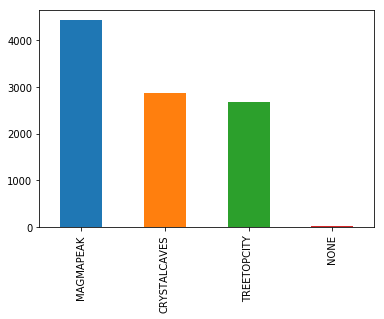

In [57]:
train_sample.world.value_counts().plot.bar()

## Investigate Test Data
It's important to see how this data set compares to the training dataset.

In [16]:
test.head()

,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world
0,27253bdc,0ea9ecc81a565215,2019-09-10T16:50:24.910Z,"{""event_code"": 2000, ""event_count"": 1}",00abaee7,1,2000,0,Welcome to Lost Lagoon!,Clip,NONE
1,27253bdc,c1ea43d8b8261d27,2019-09-10T16:50:55.503Z,"{""event_code"": 2000, ""event_count"": 1}",00abaee7,1,2000,0,Magma Peak - Level 1,Clip,MAGMAPEAK
2,27253bdc,7ed86c6b72e725e2,2019-09-10T16:51:51.805Z,"{""event_code"": 2000, ""event_count"": 1}",00abaee7,1,2000,0,Magma Peak - Level 2,Clip,MAGMAPEAK
3,27253bdc,7e516ace50e7fe67,2019-09-10T16:53:12.825Z,"{""event_code"": 2000, ""event_count"": 1}",00abaee7,1,2000,0,Crystal Caves - Level 1,Clip,CRYSTALCAVES
4,7d093bf9,a022c3f60ba547e7,2019-09-10T16:54:12.115Z,"{""version"":""1.0"",""round"":0,""event_count"":1,""ga...",00abaee7,1,2000,0,Chow Time,Game,CRYSTALCAVES


In [17]:
print('num of installation IDS: ', (len(test.installation_id.unique())))
print('num of installs that attempted assessment ', test.groupby('installation_id').type.value_counts().unstack().Assessment.count())
percent = test.groupby('installation_id').type.value_counts().unstack().Assessment.count() / len(test.installation_id.unique())
print('percentage ', percent )

num of installation IDS:  1000
num of installs that attempted assessment  1000
percentage  1.0


As you can see, unlike the training set, the test set has no installation ID"s that never took an assessment. This will be important to keep in mind later on.

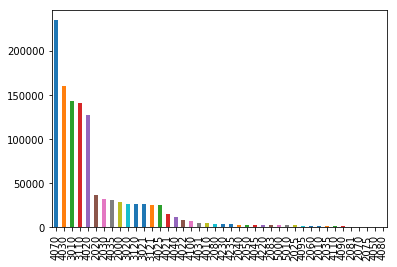

In [58]:
test.event_code.value_counts().plot.bar()

The graph of event code for the test data looks almost identitical to the train data.

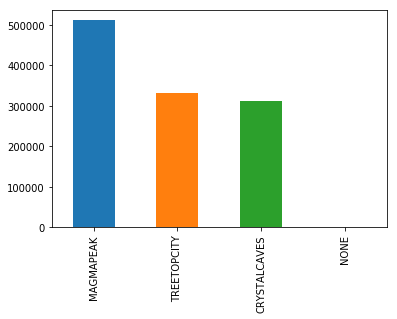

In [59]:
test.world.value_counts().plot.bar()

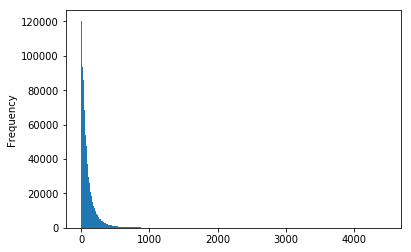

In [60]:
test.event_count.plot.hist(bins=500)

The distributions of both event count and world look very similiar to train data sets.

## summarize train labels data

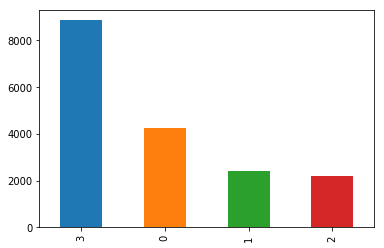

In [61]:
train_labels.accuracy_group.value_counts().plot.bar()

In [62]:
train_labels.installation_id.nunique()

3614

We see that 3 is the most common accuracy score, occuring almost 50% of the time. We also want to note that there are 3614 unique installation ids in the train labels set. Many installation ids have assessment scores for multiple different assessments and game sessions.

## Explore the Data in context of the problem


### Important information to know for data pre-proccesing
Some very important information was given to us by PBS. Firstly its important to know that assessments attempts are marked with and event code of either 4100, or 4110.

We should also take note that the user begining any type of event is marked with an event code of 2000.

Were are asked to predict for each installation ID, What their final assessment score is going to be.
To do this we want to use all of the installation IDs play history up until the assesment to predict is begun.

We can see that for any individual installation ID, the last row of Test DF is always an assesment with event code 200.
We will try to get our training data into a similar working format.

In [23]:
test.groupby('installation_id').tail(1).event_code.value_counts()

2000    1000
Name: event_code, dtype: int64

## Walk through with single Installation ID

In [31]:
single_id = train[train.installation_id == '85697782']
single_id = single_id.sort_values('timestamp')
single_id['lastPlay_time'] = single_id['timestamp'].shift(periods=1)
single_id['time_since_lastPlay'] =( single_id['timestamp'] - single_id['lastPlay_time'])
single_id['time_since_lastPlay'] = single_id['time_since_lastPlay']/np.timedelta64(1, 's')

We have taken all of the play data for a single installation ID and put it into a data frame of its own. Then we went on to do some simple feature engineering to get the amount of time elapsed since this user last played the game. I beleive this data may be useful as children tend to forget things they learned a while back.

As stated above we want to use the history prior to the beginning of the final assessment attempted, to make a prediction for that final assessment.

So, lets find where the beginning of the final assessment is, take all the data prior to the point and make that our X.
We then want to go into training labels and find the true assessment group for that assesment, and make it our Y.

In [32]:
single_id.reset_index(inplace=True)
assessment_begins = single_id[(single_id['type'] == 'Assessment') & (single_id['event_code'] == 2000)]
assessments_with_attempts = assessment_begins[assessment_begins.game_session.isin(train_labels.game_session.unique())]
cut_off_idx = assessments_with_attempts.tail(1).index
single_id.iloc[cut_off_idx[0]]

index                                                            6012423
event_id                                                        90d848e0
game_session                                            b74ddc8c115f9857
timestamp                                     2019-08-23 14:25:09.357000
event_data             {"version":"1.0","event_count":1,"game_time":0...
installation_id                                                 85697782
event_count                                                            1
event_code                                                          2000
game_time                                                              0
title                                       Cauldron Filler (Assessment)
type                                                          Assessment
world                                                          MAGMAPEAK
date                                                          2019-08-23
hour                                               

As you can see, our X is now in the same form for a single installation ID as the test set.

In [27]:
labels_install = train_labels[train_labels['installation_id'] == '85697782']
Y = labels_install[labels_install.game_session == single_id.iloc[cut_off_idx[0]].game_session]
Y

,game_session,installation_id,title,num_correct,num_incorrect,accuracy,accuracy_group
9529,b74ddc8c115f9857,85697782,Cauldron Filler (Assessment),1,2,0.333333,1


To find our Y we simply needed to go into the train labels and find the row representing the data that corresponds to the assessment were trying to predict for.

If your wondering how train labels calculates accuracy, we can look at the corresponding assessment attempts from the train data

In [28]:
single_id[(single_id['type'] == 'Assessment') & (single_id.event_code.isin([4100, 4110])) & (single_id['game_session'] == 'b74ddc8c115f9857')]

,index,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world,date,hour,weekday_name,lastPlay_time,time_since_lastPlay
4743,6012439,392e14df,b74ddc8c115f9857,2019-08-23 14:25:26.542,"{""buckets"":[0,0,0],""correct"":false,""buckets_pl...",85697782,17,4100,17364,Cauldron Filler (Assessment),Assessment,MAGMAPEAK,2019-08-23,14,Friday,2019-08-23 14:25:25.125,1.417
4753,6012449,392e14df,b74ddc8c115f9857,2019-08-23 14:25:33.954,"{""buckets"":[0,0,0],""correct"":false,""buckets_pl...",85697782,27,4100,24787,Cauldron Filler (Assessment),Assessment,MAGMAPEAK,2019-08-23,14,Friday,2019-08-23 14:25:32.720,1.234
4762,6012458,392e14df,b74ddc8c115f9857,2019-08-23 14:25:40.359,"{""buckets"":[0,0,0],""correct"":true,""buckets_pla...",85697782,36,4100,31196,Cauldron Filler (Assessment),Assessment,MAGMAPEAK,2019-08-23,14,Friday,2019-08-23 14:25:38.759,1.600


There are 3 attempts here. To check if an attempt is succesful or not, you look at the event Data and check if correct: -> True.
Here the user fails the first 2 attempts at the Cauldron filler and succesfully completes the assessment on their third.


## pre-proccess large portion of data

In [4]:
installs = train_labels.installation_id.unique()
train_installs = train.installation_id.unique()

baselineTrain = pd.DataFrame()
installs = installs[:200]  #planning to run and save with joblib, currently running with 500 for quick reiterations of project
for install in installs:
    if install in train_installs:
        
        single_id = train[train.installation_id == install]
        single_id = single_id.sort_values('timestamp')
        single_id['lastPlay_time'] = single_id['timestamp'].shift(periods=1)
        single_id['time_since_lastPlay'] =( single_id['timestamp'] - single_id['lastPlay_time'])
        single_id['time_since_lastPlay'] = single_id['time_since_lastPlay']/np.timedelta64(1, 's')

        single_id.reset_index(inplace=True)
        assessment_begins = single_id[(single_id['type'] == 'Assessment') & (single_id['event_code'] == 2000)]
        assessments_with_attempts = assessment_begins[assessment_begins.game_session.isin(train_labels.game_session.unique())]
        cut_off_idx = assessments_with_attempts.tail(1).index

        X = single_id.iloc[:cut_off_idx[0] + 1]


        labels_install = train_labels[train_labels['installation_id'] == install]
        Y = labels_install[labels_install.game_session == single_id.iloc[cut_off_idx[0]].game_session]

        toAppend = pd.DataFrame({'installation_id' : [X.iloc[0].installation_id]})
        toAppend['event_count'] = X.event_count.mean()
        toAppend['event_code'] = X.event_code.mean()
        toAppend['hour'] = X.hour.mean()
        toAppend['time_since_lastPlay'] = X.time_since_lastPlay.mean()
        toAppend['game_time'] = X.game_time.mean()
        toAppend['accuracy_group'] = Y.iloc[0].accuracy_group
        toAppend['Magma_World_count'] = X[X.world == 'MAGMAPEAK'].size      
        toAppend['Crystal_World_count'] = X[X.world == 'CRYSTALCAVES'].size
        toAppend['Treetop_World_count'] = X[X.world == 'TREETOPCITY'].size
        toAppend['None_World_count'] = X[X.world == 'NONE'].size
        toAppend['game_count'] = X[X.type == 'Game'].size
        toAppend['clip_count'] = X[X.type == 'Clip'].size
        toAppend['Activity_count'] = X[X.type == 'Activity'].size
        toAppend['Assessment_count'] = X[X.type == 'Assessment'].size


        
        baselineTrain = baselineTrain.append(toAppend)

In [ ]:
activity_gameTimes = toSummarize.groupby(['installation_id']).game_time.sum().unstack().fillna(0)
activity_gameTimes.rename(columns = {'Activity' : 'Activty_Time', 'Clip' : 'Clip_Time', 'Game' : 'Game_Time', 'Assessment' : 'Assessment_Time'}, inplace=True)
pd.merge(baselineTrain, activity_gameTimes)

while the method above was effective, this only created one data point for each session ID. It would be much better if we had data that matched the train labels. We will do this by groupying on game_session as well. We will also engineer more useful features.

We are going to keep the data from the previous function as we will still use it for our second obj clustering.

## final train prepoccesing function

In [147]:

proccessed = pd.DataFrame()

to_train = train.iloc[:100000]
for i, frame in to_train.groupby(['installation_id', 'game_session']):
    assessBegins = frame[(frame['type'] == 'Assessment') & (frame['event_code'] == 2000)]
    if len(assessBegins) > 0:
        assesswithAttempts = assessBegins[assessBegins.game_session.isin(train_labels.game_session.unique())]
        if(len(assesswithAttempts) > 0):

            cut_off_idx = train[train.installation_id == frame.installation_id.iloc[0]]
            cut_off_idx = cut_off_idx[cut_off_idx.game_session == frame.game_session.iloc[0]]
            cut_off_idx  = cut_off_idx[cut_off_idx.event_code == 2000]
            cut_off_idx = cut_off_idx[cut_off_idx.type == 'Assessment']
            
            toSummarize = train.iloc[:cut_off_idx.index[0] + 1]
            toSummarize = toSummarize[toSummarize.installation_id == frame.installation_id.iloc[0]]
           
            typecountsWorld =  toSummarize.groupby('world').type.value_counts().unstack()
            typecountsWorld = pd.DataFrame(typecountsWorld.fillna(0).stack()).transpose()
            toAppend = pd.DataFrame()
            
            if typecountsWorld.columns.levels[0].contains('MAGMAPEAK'):
                try:
                    toAppend['MagmaAssessmentCount'] = typecountsWorld['MAGMAPEAK']['Assessment']
                except:
                    toAppend['MagmaAssessmentCount'] = 0
                try:
                    toAppend['MagmaClipCount'] = typecountsWorld['MAGMAPEAK']['Clip']
                except:
                    toAppend['MagmaClipCount'] = 0

                try:
                    toAppend['MagmaActivityCount'] = typecountsWorld['MAGMAPEAK']['Activity']
                except:
                    toAppend['MagmaActivityCount'] = 0

                try:
                    toAppend['MagmaGameCount'] = typecountsWorld['MAGMAPEAK']['Game']
                except:
                    toAppend['MagmaGameCount'] = 0
                    
            else:
                toAppend['MagmaAssessmentCount'] = 0
                toAppend['MagmaClipCount'] = 0
                toAppend['MagmaActivityCount'] = 0
                toAppend['MagmaGameCount'] = 0
                
            
            if typecountsWorld.columns.levels[0].contains('TREETOPCITY'):
                try:
                    toAppend['TreeAssessmentCount'] = typecountsWorld['TREETOPCITY']['Assessment']
                except:
                    toAppend['TreeAssessmentCount'] = 0
                try:
                    toAppend['TreeClipCount'] = typecountsWorld['TREETOPCITY']['Clip']
                except:
                    toAppend['TreeClipCount'] = 0
                try:
                    toAppend['TreeActivityCount'] = typecountsWorld['TREETOPCITY']['Activity']
                except:
                    toAppend['TreeActivityCount'] = 0
                try:
                    toAppend['TreeGameCount'] = typecountsWorld['TREETOPCITY']['Game']
                except:
                    toAppend['TreeGameCount'] = 0

            else:
                toAppend['TreeAssessmentCount'] = 0
                toAppend['TreeClipCount'] = 0
                toAppend['TreeActivityCount'] = 0
                toAppend['TreeGameCount'] = 0

                
                
            if typecountsWorld.columns.levels[0].contains('CRYSTALCAVES'):
                try:
                    toAppend['CrystalAssessmentCount'] = typecountsWorld['CRYSTALCAVES']['Assessment']
                except:
                    toAppend['CrystalAssessmentCount'] = 0
                try:
                    toAppend['CrystalClipCount'] = typecountsWorld['CRYSTALCAVES']['Clip']
                except:
                    toAppend['CrystalClipCount'] = 0
                try:
                    toAppend['CrystalActivityCount'] = typecountsWorld['CRYSTALCAVES']['Activity']
                except:
                    toAppend['CrystalActivityCount'] = 0
                try:
                    toAppend['CrystalGameCount'] = typecountsWorld['CRYSTALCAVES']['Game']
                
                except:
                    toAppend['CrystalGameCount'] = 0
                    
            else:
                toAppend['CrystalAssessmentCount'] = 0
                toAppend['CrystalClipCount'] = 0
                toAppend['CrystalActivityCount'] = 0
                toAppend['CrystalGameCount'] = 0

            Assess = toSummarize[(toSummarize.type == 'Assessment') & (toSummarize.world == toSummarize.tail(1).world.iloc[0])]
            toAppend['CorrectAtts'] = Assess[Assess['event_data'].str.contains('true')].size
            toAppend['FalseAtts'] = Assess[Assess['event_data'].str.contains('false')].size
            
            
            toAppend['time_sinceLastAtt'] = (Assess[Assess.event_code == 2000].tail(2).iloc[0].timestamp  - toSummarize.tail(1).timestamp.iloc[0]) 
            toAppend['time_sinceLastAtt'] = toAppend['time_sinceLastAtt'] / np.timedelta64(1, 's')
            toAppend['installation_id'] = i[0]
            toAppend['game_session'] = i[1]
            

            proccessed = proccessed.append(toAppend)
    

## Investigate features by accuracy group

In [33]:
acc_grouped_df = baselineTrain.groupby('accuracy_group')

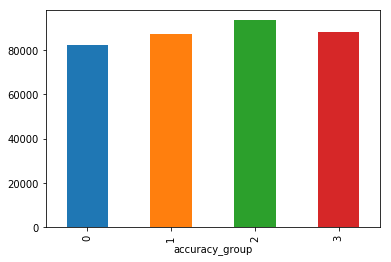

In [65]:
acc_grouped_df.game_time.mean().plot.bar()

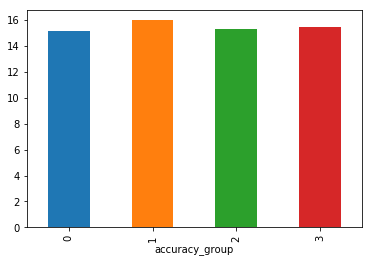

In [35]:
acc_grouped_df.hour.mean().plot.bar()

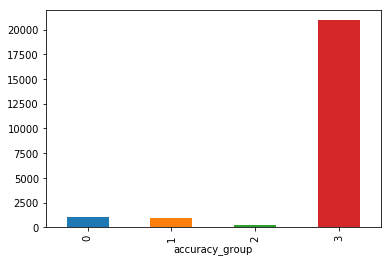

In [36]:
acc_grouped_df.time_since_lastPlay.mean().plot.bar()

This is Awesome to see! it means I potentially created a feature that will be useful in predicting accuracy group. Lets look into this a little more.

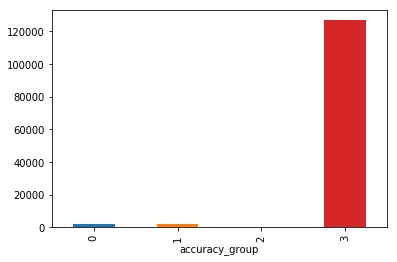

In [37]:
acc_grouped_df.time_since_lastPlay.std().plot.bar()

As you can see the std of the time since last play for accuracy group 3 is is very large. however its nearly none existent for group 2. this could mean a number very close to the mean of accuracy group 2 could be a good indicator.

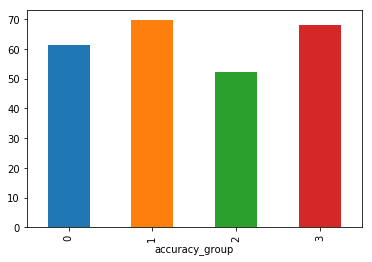

In [38]:
acc_grouped_df.event_count.mean().plot.bar()

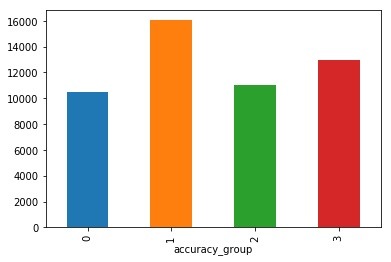

In [66]:
acc_grouped_df.Magma_World_count.mean().plot.bar()

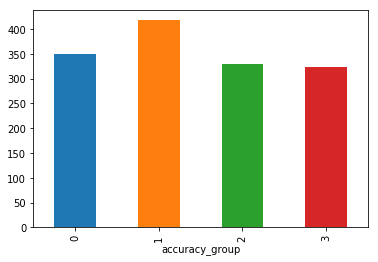

In [71]:
acc_grouped_df.clip_count.mean().plot.bar()

## Create Model

-------------FITTING MODELS-------------


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


-------------SCORING MODELS-------------


[Parallel(n_jobs=-1)]: Done   2 out of   8 | elapsed:    6.2s remaining:   18.9s
[Parallel(n_jobs=-1)]: Done   3 out of   8 | elapsed:    6.2s remaining:   10.4s
[Parallel(n_jobs=-1)]: Done   4 out of   8 | elapsed:    6.2s remaining:    6.2s
[Parallel(n_jobs=-1)]: Done   5 out of   8 | elapsed:    6.2s remaining:    3.7s
[Parallel(n_jobs=-1)]: Done   6 out of   8 | elapsed:    6.2s remaining:    2.0s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    6.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    6.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    0.0s finished


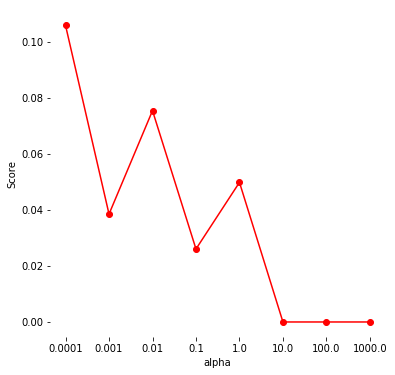

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=None,
       n_iter=1000, n_iter_no_change=5, n_jobs=-1, penalty='l2',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False) 0.10601719197707749


In [181]:
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction import DictVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import cohen_kappa_score
from sklearn.model_selection import train_test_split
import parfit.parfit as pf
from sklearn.model_selection import ParameterGrid
from sklearn.linear_model import SGDClassifier


X = proccessed.fillna(0).drop(columns = ['installation_id', 'game_session'])

y = train_labels.iloc[:len(X)].accuracy_group

X_dict = X.to_dict(orient='records')

vec = DictVectorizer(sparse=False)
vec.fit(X_dict)

X = vec.transform(X_dict)

# Standardization
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, shuffle=True, random_state=42)

# K-Nearest Neighbors Model
model = KNeighborsClassifier(n_neighbors=5)
model.fit(X_train, y_train)

KNNpredictions = model.predict(X_test)


#SGD classifier

import parfit.parfit as pf

##found this grid online:
grid = {

    'alpha': [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3], # learning rate

    'n_iter': [1000], # number of epochs

    'loss': ['log'], # logistic regression,

    'penalty': ['l2'],

    'n_jobs': [-1]

}


paramGrid = ParameterGrid(grid)


bestModel, bestScore, allModels, allScores = pf.bestFit(SGDClassifier, paramGrid,

           X_train, y_train, X_test, y_test, 

           metric = cohen_kappa_score)



print(bestModel, bestScore)

SGDpredictions = bestModel.predict(X_test)

## Evaluate baseline model

In [182]:
print('KNN kappa score', cohen_kappa_score(y_test, KNNpredictions))
print('KNN accuracy score', accuracy_score(y_test, KNNpredictions))

print('SGD kappa score', cohen_kappa_score(y_test, SGDpredictions))
print('SGD accuracy score', accuracy_score(y_test, SGDpredictions))



KNN kappa score -0.049180327868852514
KNN accuracy score 0.3333333333333333
SGD kappa score 0.10601719197707749
SGD accuracy score 0.4583333333333333


## Proccess Test Data 

In [195]:
testProccessed = pd.DataFrame()

test['timestamp'] = pd.to_datetime(test['timestamp'])

for i, frame in test.groupby(['installation_id']):
    
    typecountsWorld =  frame.groupby('world').type.value_counts().unstack()
    typecountsWorld = pd.DataFrame(typecountsWorld.fillna(0).stack()).transpose()
    toAppend = pd.DataFrame()
            
    if typecountsWorld.columns.levels[0].contains('MAGMAPEAK'):
        try:
            toAppend['MagmaAssessmentCount'] = typecountsWorld['MAGMAPEAK']['Assessment']
        except:
            toAppend['MagmaAssessmentCount'] = 0
        try:
            toAppend['MagmaClipCount'] = typecountsWorld['MAGMAPEAK']['Clip']
        except:
            toAppend['MagmaClipCount'] = 0

        try:
            toAppend['MagmaActivityCount'] = typecountsWorld['MAGMAPEAK']['Activity']
        except:
            toAppend['MagmaActivityCount'] = 0

        try:
            toAppend['MagmaGameCount'] = typecountsWorld['MAGMAPEAK']['Game']
        except:
            toAppend['MagmaGameCount'] = 0
                    
        else:
            toAppend['MagmaAssessmentCount'] = 0
            toAppend['MagmaClipCount'] = 0
            toAppend['MagmaActivityCount'] = 0
            toAppend['MagmaGameCount'] = 0
                
            
        if typecountsWorld.columns.levels[0].contains('TREETOPCITY'):
            try:
                toAppend['TreeAssessmentCount'] = typecountsWorld['TREETOPCITY']['Assessment']
            except:
                toAppend['TreeAssessmentCount'] = 0
            try:
                toAppend['TreeClipCount'] = typecountsWorld['TREETOPCITY']['Clip']
            except:
                toAppend['TreeClipCount'] = 0
            try:
                toAppend['TreeActivityCount'] = typecountsWorld['TREETOPCITY']['Activity']
            except:
                toAppend['TreeActivityCount'] = 0
            try:
                toAppend['TreeGameCount'] = typecountsWorld['TREETOPCITY']['Game']
            except:
                toAppend['TreeGameCount'] = 0

        else:
            toAppend['TreeAssessmentCount'] = 0
            toAppend['TreeClipCount'] = 0
            toAppend['TreeActivityCount'] = 0
            toAppend['TreeGameCount'] = 0

                
                
        if typecountsWorld.columns.levels[0].contains('CRYSTALCAVES'):
            try:
                toAppend['CrystalAssessmentCount'] = typecountsWorld['CRYSTALCAVES']['Assessment']
            except:
                toAppend['CrystalAssessmentCount'] = 0
            try:
                toAppend['CrystalClipCount'] = typecountsWorld['CRYSTALCAVES']['Clip']
            except:
                toAppend['CrystalClipCount'] = 0
            try:
                toAppend['CrystalActivityCount'] = typecountsWorld['CRYSTALCAVES']['Activity']
            except:
                toAppend['CrystalActivityCount'] = 0
            try:
                toAppend['CrystalGameCount'] = typecountsWorld['CRYSTALCAVES']['Game']
                
            except:
                toAppend['CrystalGameCount'] = 0
                    
        else:
            toAppend['CrystalAssessmentCount'] = 0
            toAppend['CrystalClipCount'] = 0
            toAppend['CrystalActivityCount'] = 0
            toAppend['CrystalGameCount'] = 0

        Assess = frame[(frame.type == 'Assessment') & (frame.world == frame.tail(1).world.iloc[0])]
        toAppend['CorrectAtts'] = Assess[Assess['event_data'].str.contains('true')].size
        toAppend['FalseAtts'] = Assess[Assess['event_data'].str.contains('false')].size
            
            
        toAppend['time_sinceLastAtt'] = (Assess[Assess.event_code == 2000].tail(2).iloc[0].timestamp  - frame.tail(1).timestamp.iloc[0]) 
        toAppend['time_sinceLastAtt'] = toAppend['time_sinceLastAtt'] / np.timedelta64(1, 's')
        toAppend['installation_id'] = i
        testProccessed = testProccessed.append(toAppend)
            
    

## Create prediction for submission

In [196]:
installs = testProccessed.installation_id

Xtest = testProccessed.fillna(0).drop(columns = ['installation_id'])
X_dict = Xtest.to_dict(orient='records')
vec = DictVectorizer(sparse=False)
vec.fit(X_dict)

Xtest = vec.transform(X_dict)

# Standardization
scaler = StandardScaler()
scaler.fit(Xtest)
Xtest = scaler.transform(Xtest)

testPredictions = bestModel.predict(Xtest)

In [199]:
submission = pd.DataFrame({'installation_id' : installs, 'accuracy_group' : testPredictions})


In [198]:
submission.head()

,installation_id,accuracy_group
0,00abaee7,3
0,01242218,3
0,01bc6cb6,3
0,02256298,3
0,0267757a,0


## Second Objective

### Plan
#####  - Use unsupervised learning to cluster micro and macro time data for each installation ID
##### - Compare the Distribution of clusters to the distribution of accuracy score

C:\Users\will hitchcock\anaconda\lib\site-packages\pandas\core\frame.py:3790: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


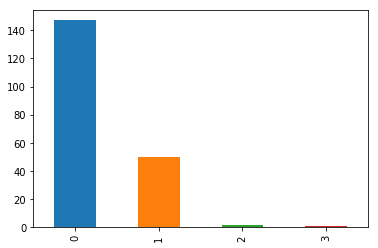

In [8]:
from sklearn.cluster import KMeans

timeTrain = baselineTrain[['time_since_lastPlay','Assessment_Time', 'Game_Time', 'Activty_Time', 'hour' ]]

timeTrain.fillna(0, inplace=True)

timeTrain_dict = timeTrain.to_dict(orient='records')
#X_val_dict = X_val.to_dict(orient='records')

vec = DictVectorizer(sparse=False)
vec.fit(timeTrain_dict)

timeTrain = vec.transform(timeTrain_dict)

# Standardization
scaler = StandardScaler()
scaler.fit(timeTrain)
timeTrain = scaler.transform(timeTrain)


model = KMeans(n_clusters=4)
model.fit(timeTrain)

centroids = model.cluster_centers_
clusters = model.labels_

clusterDf = pd.DataFrame({'accuracy' : clusters})
clusterDf.accuracy.value_counts().plot.bar()


In [15]:
clusterDf['true_accuracy'] = y

In [26]:
letterMap = {3 : 'A' , 2 : 'B', 1: 'C', 0 : 'D'}
clusterDf = clusterDf.replace({'accuracy' : letterMap})

In [28]:
clusterDf.groupby('accuracy').true_accuracy.value_counts().unstack()

true_accuracy,0,1,2,3
accuracy,,,,
A,NaN,NaN,NaN,1.0
B,1.0,NaN,NaN,1.0
C,13.0,9.0,6.0,22.0
D,42.0,15.0,25.0,65.0


To the raw eye, it doesnt appear that these clusters really correlate to difference accuracy score

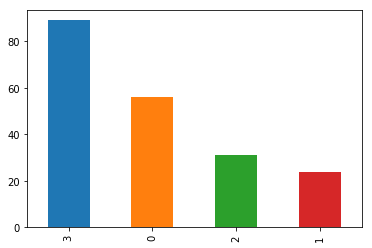

In [107]:
pd.DataFrame({'accuracy' : y}).accuracy.value_counts().plot.bar()

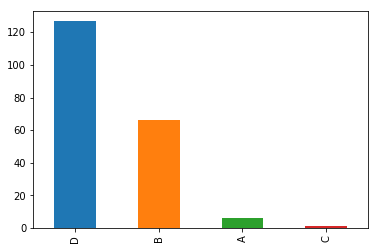

In [109]:
clusterDf.accuracy.value_counts().plot.bar()

In [162]:
from scipy.stats import chisquare

chisquare(clusterDf.accuracy, clusterDf.true_accuracy)

NameError: name 'clusterDf' is not defined

looking at the chiSquare we can see that the clusters are a poor representiation of accuracy score.